<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/6_Scratch_Focal_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [1]:
!nvidia-smi

Thu Jun 18 03:15:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from ham10000_6classes_utils_functions import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should 

In [3]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters

In [4]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7

LR = 1e-5 # Learning rate

# Data

In [5]:
!git clone https://github.com/EvilPickle-PCSHSPT/6_classes_HAM10000_split

fatal: destination path '6_classes_HAM10000_split' already exists and is not an empty directory.


In [6]:
train_path = '/content/6_classes_HAM10000_split/train' 
val_path = '/content/6_classes_HAM10000_split/val'
test_path = '/content/6_classes_HAM10000_split/test'

## Data Augmentation

In [7]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_aug.flow_from_directory(train_path, 
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='categorical') 

val_generator = val_aug.flow_from_directory(val_path, 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True,
                                              class_mode='categorical') 

test_generator = test_aug.flow_from_directory(test_path, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               batch_size=1, 
                                               shuffle=False,
                                               class_mode=None) 

Found 2080 images belonging to 6 classes.
Found 896 images belonging to 6 classes.
Found 334 images belonging to 6 classes.


# Class Weights

In [9]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

In [10]:
class_weights_dict = { i : class_weights[i] for i in range(0, len(class_weights) ) }

In [11]:
class_weights_dict

{0: 1.6910569105691058,
 1: 1.0732714138286894,
 2: 0.5009633911368016,
 3: 4.814814814814815,
 4: 0.49523809523809526,
 5: 3.9393939393939394}

# Model

## Build

In [12]:
def build_model():
  base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')

  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  
  # fc_layer = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(average_pooling_layer)
  # fc_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  # fc_layer = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  # bn_layer = tf.keras.layers.BatchNormalization()(fc_layer)
  # dropout_layer = tf.keras.layers.Dropout(0.25)(bn_layer)
  prediction_layer = tf.keras.layers.Dense(units=6, activation='softmax', name='prediction')(average_pooling_layer)

  model = Model(inputs=base_model.input, outputs=prediction_layer)

  return model

In [13]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Focal Loss
https://github.com/umbertogriffo/focal-loss-keras

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)$$

In [15]:
def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m 
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(loss, axis=1)

    return categorical_focal_loss_fixed

## Compile

In [16]:
model.compile(optimizer=Adam(LR), 
              loss=[categorical_focal_loss(gamma=2., alpha=.25)],
              metrics=['accuracy'])

## Callbacks

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='6_scratch_focal_vgg16_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7, patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [18]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    callbacks=[early_stop, model_checkpoint, reduce_lr_rate],
                    verbose=1)

Epoch 1/100
65/65 [==============================] - 40s 621ms/step - loss: 0.0402 - accuracy: 0.3452 - val_loss: 0.0344 - val_accuracy: 0.4520 - lr: 1.0000e-05
Epoch 2/100
65/65 [==============================] - 39s 599ms/step - loss: 0.0318 - accuracy: 0.4673 - val_loss: 0.0287 - val_accuracy: 0.5190 - lr: 1.0000e-05
Epoch 3/100
65/65 [==============================] - 39s 593ms/step - loss: 0.0272 - accuracy: 0.5413 - val_loss: 0.0246 - val_accuracy: 0.5938 - lr: 1.0000e-05
Epoch 4/100
65/65 [==============================] - 39s 599ms/step - loss: 0.0236 - accuracy: 0.5885 - val_loss: 0.0230 - val_accuracy: 0.5781 - lr: 1.0000e-05
Epoch 5/100
65/65 [==============================] - 39s 596ms/step - loss: 0.0198 - accuracy: 0.6433 - val_loss: 0.0202 - val_accuracy: 0.6384 - lr: 1.0000e-05
Epoch 6/100
65/65 [==============================] - 39s 596ms/step - loss: 0.0186 - accuracy: 0.6639 - val_loss: 0.0187 - val_accuracy: 0.6562 - lr: 1.0000e-05
Epoch 7/100
65/65 [===============

# Graph

## Accuracy

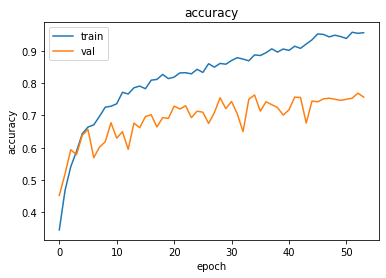

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

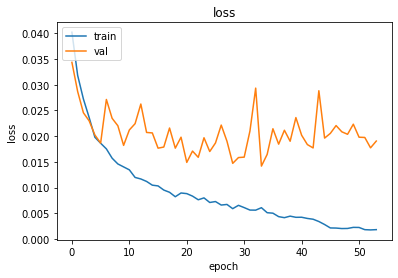

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [21]:
import dill

In [22]:
custom_object = {'categorical_focal_loss_fixed': dill.loads(dill.dumps(categorical_focal_loss(gamma=2., alpha=.25))),
                 'categorical_focal_loss': categorical_focal_loss}

In [23]:
test_model = tf.keras.models.load_model('/content/6_scratch_focal_vgg16_model.h5', custom_objects=custom_object)

In [24]:
num_test_files = len(test_generator.filenames)

In [25]:
test_generator.reset()

In [26]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

## Confusion Matrix

### Without Normalize

Confusion matrix, without normalization
[[ 17   6   6   0   4   0]
 [  2  41   3   4   2   0]
 [  2   3  80   0  25   0]
 [  2   0   2   6   2   0]
 [  2   3   5   0 102   0]
 [  0   3   0   0   0  12]]


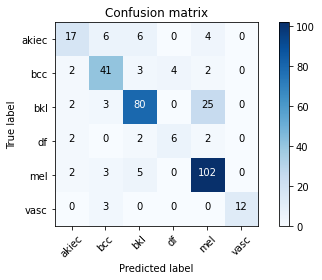

In [27]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc']

plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[0.51515152 0.18181818 0.18181818 0.         0.12121212 0.        ]
 [0.03846154 0.78846154 0.05769231 0.07692308 0.03846154 0.        ]
 [0.01818182 0.02727273 0.72727273 0.         0.22727273 0.        ]
 [0.16666667 0.         0.16666667 0.5        0.16666667 0.        ]
 [0.01785714 0.02678571 0.04464286 0.         0.91071429 0.        ]
 [0.         0.2        0.         0.         0.         0.8       ]]


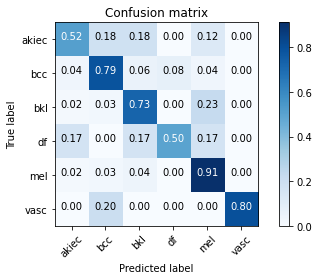

In [28]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [29]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[ 17   6   6   0   4   0]
 [  2  41   3   4   2   0]
 [  2   3  80   0  25   0]
 [  2   0   2   6   2   0]
 [  2   3   5   0 102   0]
 [  0   3   0   0   0  12]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.68      0.52      0.59        33
         bcc       0.73      0.79      0.76        52
         bkl       0.83      0.73      0.78       110
          df       0.60      0.50      0.55        12
         mel       0.76      0.91      0.83       112
        vasc       1.00      0.80      0.89        15

    accuracy                           0.77       334
   macro avg       0.77      0.71      0.73       334
weighted avg       0.78      0.77      0.77       334



## Sensitivity & Specificity

In [30]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [31]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.7391
specificity: 0.9535


# Grad-CAM

In [32]:
last_conv2d = 'block5_conv3'

## AKIEC

In [33]:
akiec_img = '/content/6_classes_HAM10000_split/train/akiec/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.987
	bkl            	(2)	with probability 0.013
	akiec          	(0)	with probability 0.000
	df             	(3)	with probability 0.000
	bcc            	(1)	with probability 0.000
Explanation for 'mel'


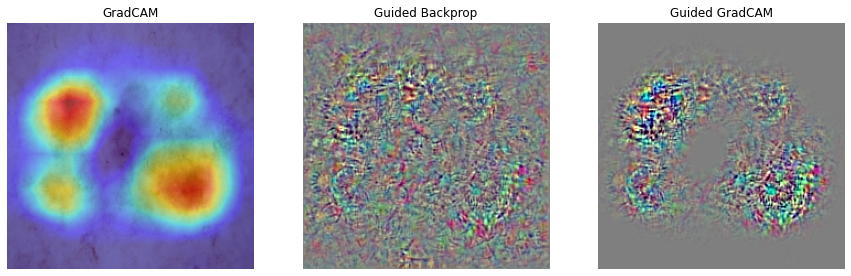

In [45]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, akiec_img, layer_name=last_conv2d)

## BCC

In [46]:
bcc_img = '/content/6_classes_HAM10000_split/train/bcc/ISIC_0024332.jpg'

Model prediction:
	mel            	(4)	with probability 0.840
	bcc            	(1)	with probability 0.053
	akiec          	(0)	with probability 0.049
	bkl            	(2)	with probability 0.042
	df             	(3)	with probability 0.016
Explanation for 'mel'


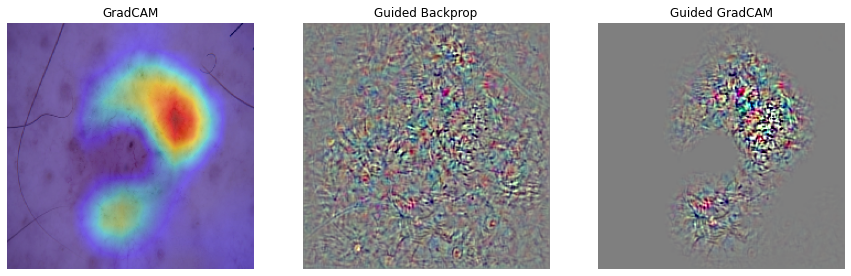

In [47]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, bcc_img, layer_name=last_conv2d)

## BKL

In [48]:
bkl_img = '/content/6_classes_HAM10000_split/train/bkl/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.964
	bkl            	(2)	with probability 0.036
	df             	(3)	with probability 0.000
	bcc            	(1)	with probability 0.000
	akiec          	(0)	with probability 0.000
Explanation for 'mel'


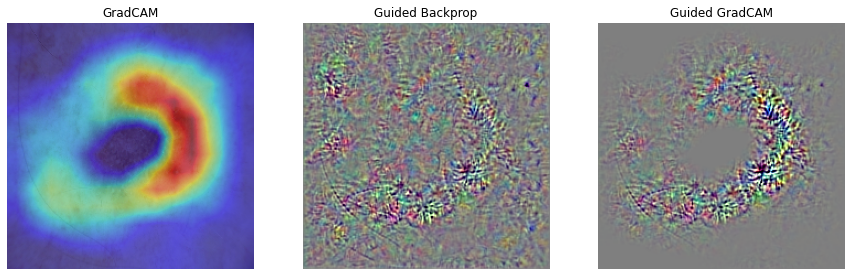

In [49]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, bkl_img, layer_name=last_conv2d)

## DF

In [50]:
df_img = '/content/6_classes_HAM10000_split/val/df/ISIC_0033626.jpg'

Model prediction:
	mel            	(4)	with probability 0.957
	bkl            	(2)	with probability 0.037
	df             	(3)	with probability 0.005
	akiec          	(0)	with probability 0.001
	bcc            	(1)	with probability 0.000
Explanation for 'mel'


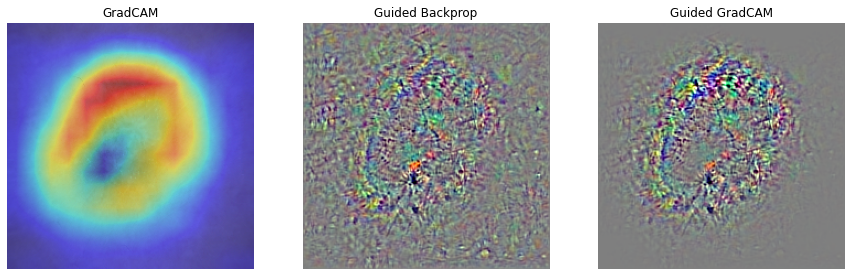

In [51]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, df_img, layer_name=last_conv2d)

## MEL

In [52]:
mel_img = '/content/6_classes_HAM10000_split/train/mel/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.998
	bkl            	(2)	with probability 0.002
	akiec          	(0)	with probability 0.000
	df             	(3)	with probability 0.000
	bcc            	(1)	with probability 0.000
Explanation for 'mel'


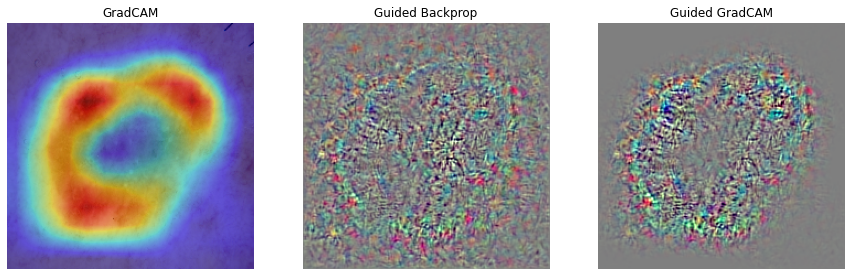

In [53]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, mel_img, layer_name=last_conv2d)

## VASC

In [54]:
vasc_img = '/content/6_classes_HAM10000_split/test/vasc/ISIC_0025452.jpg'

Model prediction:
	vasc           	(5)	with probability 0.990
	mel            	(4)	with probability 0.010
	bkl            	(2)	with probability 0.000
	bcc            	(1)	with probability 0.000
	df             	(3)	with probability 0.000
Explanation for 'vasc'


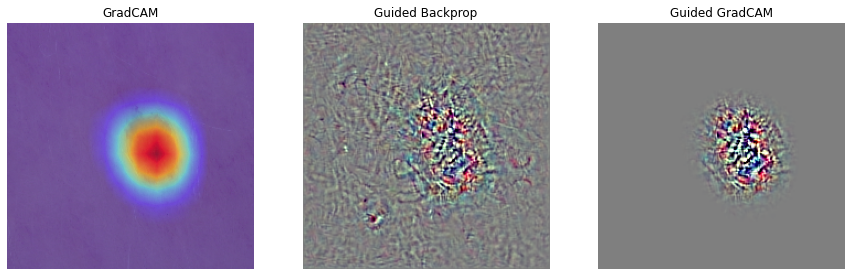

In [55]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, vasc_img, layer_name=last_conv2d)